In [19]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

sys.path.append("..")
from MLP_utils.utils import parameter_set
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)


sys.path.append("../..")
from utils.utils import df_stats

In [20]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()

In [21]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)
params.MODEL_TYPE

'Multi_Class'

In [22]:
def test_loop(df, output_name, title):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", params.IN_FEATURES)
    if params.MODEL_TYPE == "Regression":
        params.OUT_FEATURES = 1
    else:
        params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", params.OUT_FEATURES)

    if params.OUT_FEATURES > 2:
        params.MODEL_TYPE = "Multi_Class"
    elif params.OUT_FEATURES == 2:
        params.OUT_FEATURES = params.OUT_FEATURES - 1
        params.MODEL_TYPE = "Binary_Classification"
    elif params.OUT_FEATURES == 1:
        params.MODEL_TYPE = "Regression"
    else:
        pass
    print(params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(params, params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputing list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            params,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [23]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['media ctr_0_Media ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'DMSO_0.100_Z-VAD-FMK_100.0', 'DMSO_0.100_Z-VAD-FMK_30.0',
       'DMSO_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'Topotecan_5.000_DMSO_0.025',
       'Topotecan_10.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_0.1', 'LPS_10.000_Disulfiram_1.0',
       'LPS_10.000_Disulfiram_2.5',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.500_DMSO_0.025', 'H2O2_100.000_DMSO_0.025',
       'LPS_10.000_Z-VAD-FMK_100.0', 'LPS_100.000_DMSO_0.025',
       'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'LPS_Nigericin_1.000_3.0_DMSO_0.025',
       'LPS_Nigericin_1.000_1

In [24]:
paired_treatment_list = [
    ["LPS_100.000_DMSO_0.025", "H2O2_100.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "Thapsigargin_1.000_DMSO_0.025",
        "H2O2_100.000_Z-VAD-FMK_100.0",
        "DMSO_0.100_DMSO_0.025",
    ],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "LPS_100.000_DMSO_0.025",
        "Thapsigargin_1.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "LPS_10.000_DMSO_0.025",
        "Thapsigargin_10.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
    [
        "LPS_100.000_DMSO_0.025",
        "Thapsigargin_10.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
]

DMSO_0.100_DMSO_0.025 H2O2_100.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.60      0.99      0.74     35643
           1       0.04      0.03      0.03     26900
           2       0.00      0.00      0.00     15987

    accuracy                           0.46     78530
   macro avg       0.22      0.34      0.26     78530
weighted avg       0.29      0.46      0.35     78530

Precision for class 0: 0.5981098721784063
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.04421477495107632
Recall for class 1: 0.02687732342007435
Precision for class 2: 0.00328750747160789
Recall for class 2: 0.0006880590479764808
3


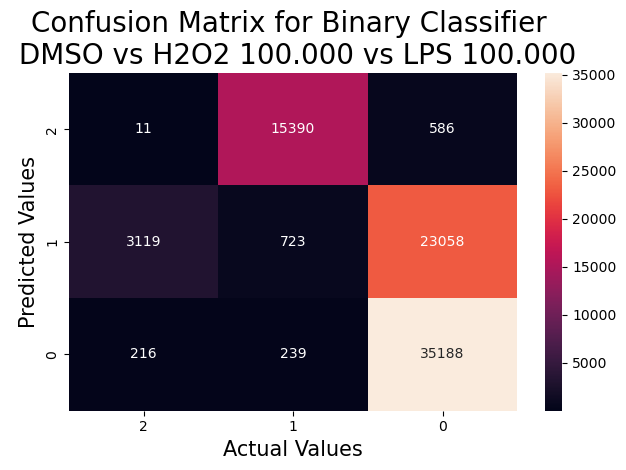

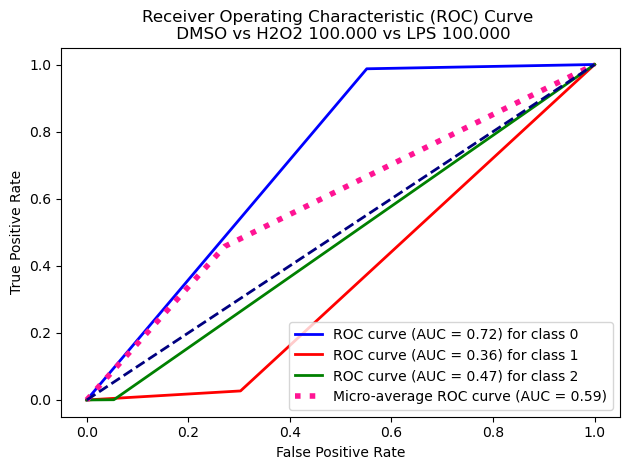

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 H2O2_100.000_Z-VAD-FMK_100.0
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.67      0.99      0.80     35643
           1       0.27      0.01      0.02     14747
           2       0.81      0.67      0.74     13766

    accuracy                           0.70     64156
   macro avg       0.59      0.56      0.52     64156
weighted avg       0.61      0.70      0.61     64156

Precision for class 0: 0.6744226161954959
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.2691029900332226
Recall for class 1: 0.010985285142740896
Precision for class 2: 0.8121979084278056
Recall for class 2: 0.6713642307133517
3


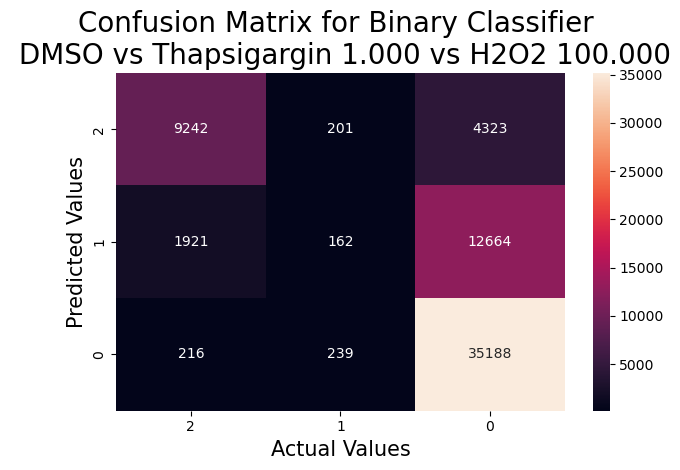

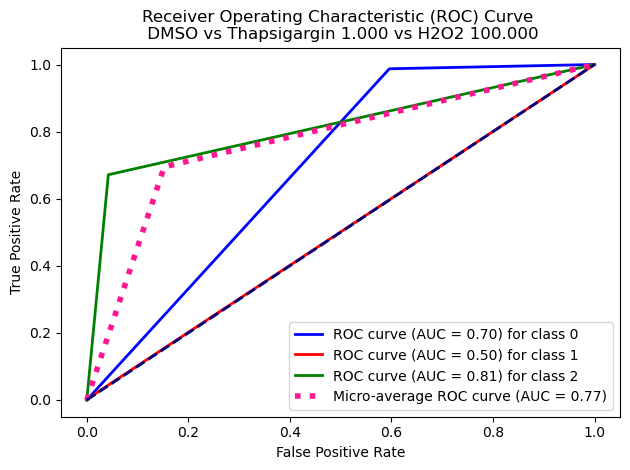

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.63      0.99      0.77     35643
           1       0.64      0.05      0.08     17510
           2       0.95      0.67      0.79     13766

    accuracy                           0.68     66919
   macro avg       0.74      0.57      0.55     66919
weighted avg       0.70      0.68      0.59     66919

Precision for class 0: 0.6292898402990146
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.6428571428571429
Recall for class 1: 0.04523129640205597
Precision for class 2: 0.945957011258956
Recall for class 2: 0.6713642307133517
3


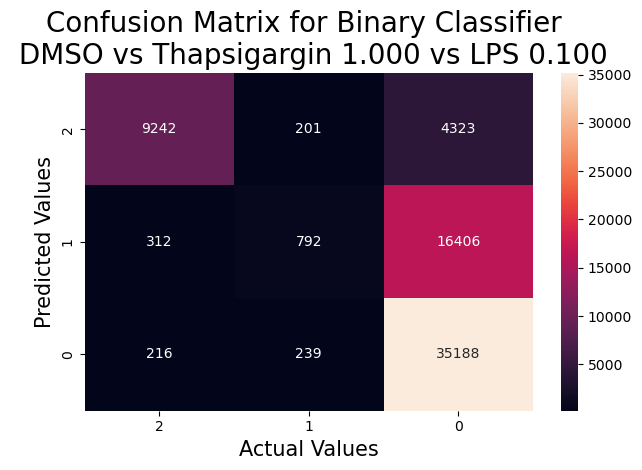

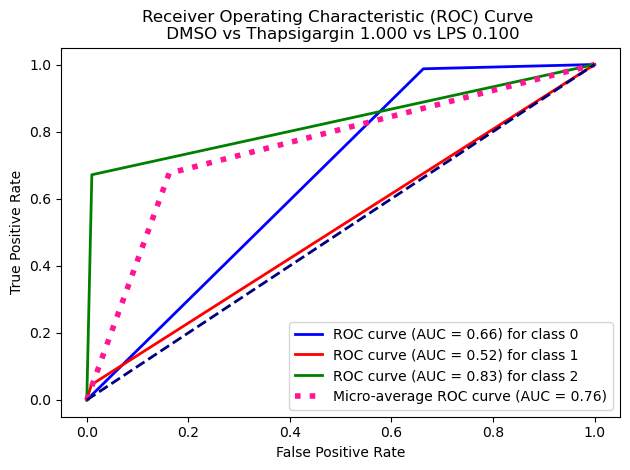

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.64      0.99      0.78     35643
           1       0.63      0.05      0.08     16458
           2       0.92      0.67      0.77     13766

    accuracy                           0.69     65867
   macro avg       0.73      0.57      0.55     65867
weighted avg       0.70      0.69      0.61     65867

Precision for class 0: 0.6446577751722117
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.6293176074136478
Recall for class 1: 0.045388261028071454
Precision for class 2: 0.9154120443740095
Recall for class 2: 0.6713642307133517
3


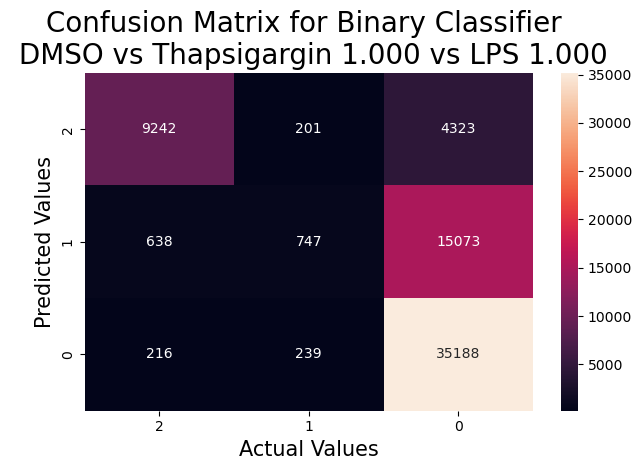

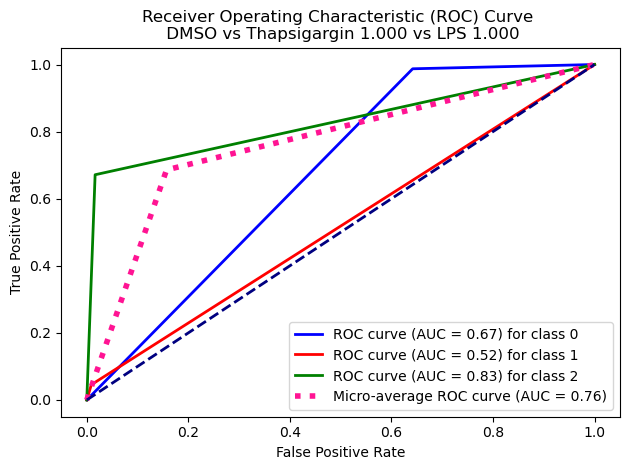

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.64      0.99      0.78     35643
           1       0.65      0.05      0.09     16810
           2       0.93      0.67      0.78     13766

    accuracy                           0.68     66219
   macro avg       0.74      0.57      0.55     66219
weighted avg       0.70      0.68      0.60     66219

Precision for class 0: 0.6398981633024187
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.6535433070866141
Recall for class 1: 0.04937537180249851
Precision for class 2: 0.9280048197610202
Recall for class 2: 0.6713642307133517
3


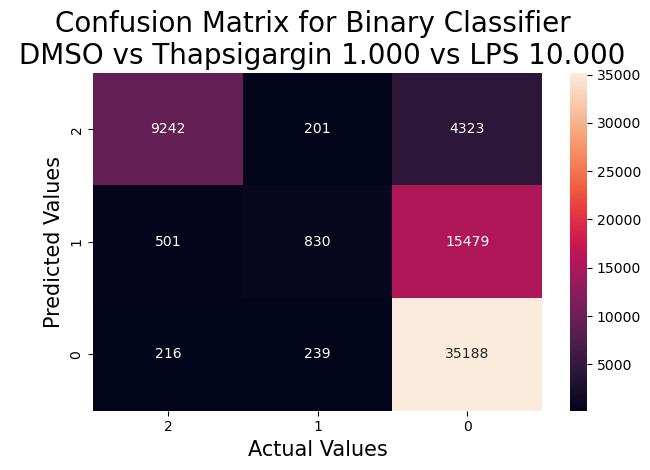

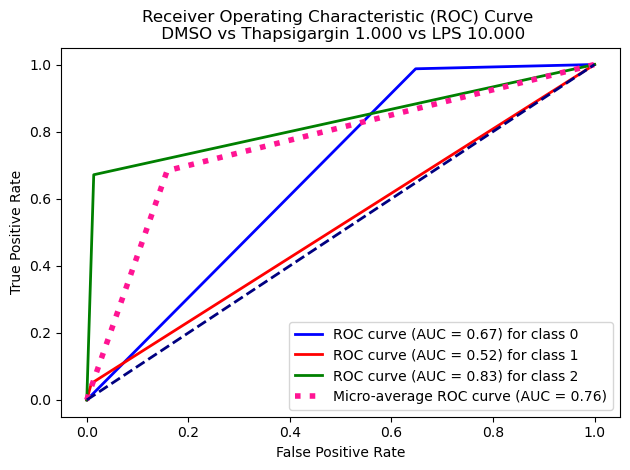

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     35643
           1       0.97      0.96      0.97     15987
           2       0.98      0.67      0.80     13766

    accuracy                           0.91     65396
   macro avg       0.94      0.87      0.90     65396
weighted avg       0.92      0.91      0.91     65396

Precision for class 0: 0.8775718881711849
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.9722046746683513
Recall for class 1: 0.9626571589416401
Precision for class 2: 0.9760270355898194
Recall for class 2: 0.6713642307133517
3


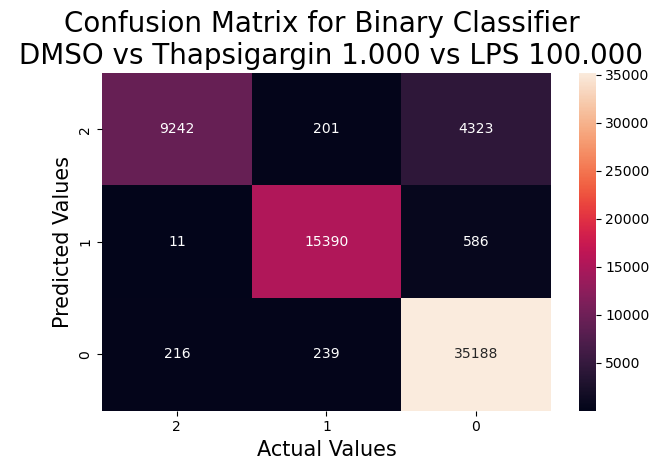

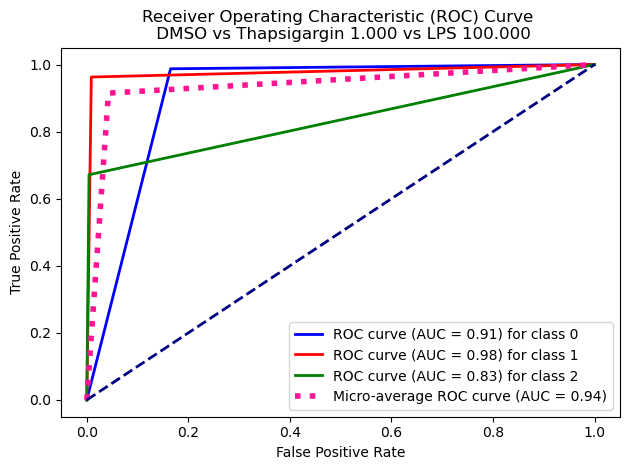

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.68      0.99      0.80     35643
           1       0.73      0.05      0.09     17510
           2       0.96      0.96      0.96     13212

    accuracy                           0.73     66365
   macro avg       0.79      0.66      0.61     66365
weighted avg       0.75      0.73      0.64     66365

Precision for class 0: 0.6750565936384914
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.7252747252747253
Recall for class 1: 0.04523129640205597
Precision for class 2: 0.9598387464820871
Recall for class 2: 0.9551165607023918
3


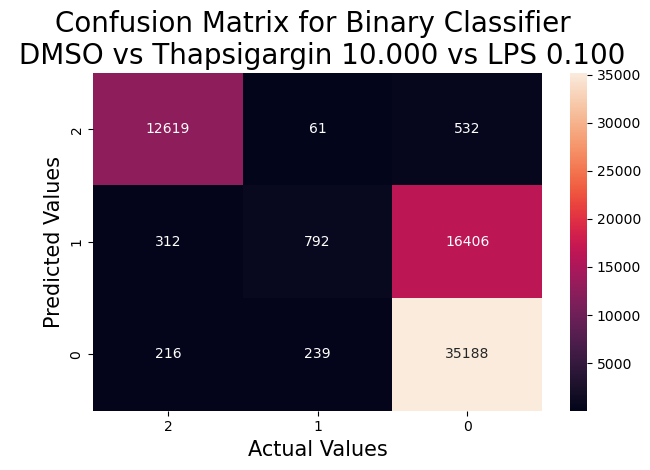

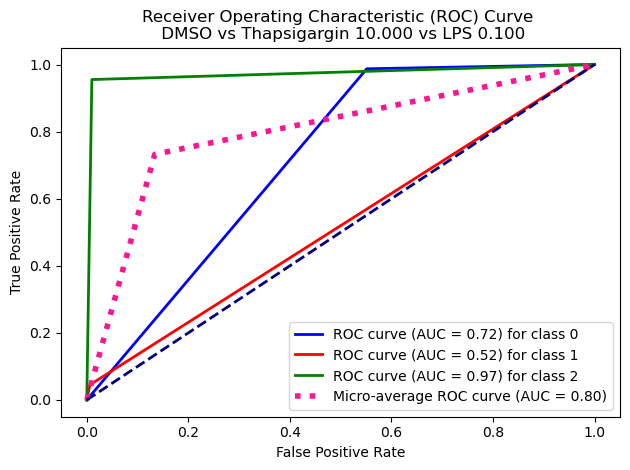

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.71      0.05      0.09     16458
           2       0.94      0.96      0.95     13212

    accuracy                           0.74     65313
   macro avg       0.78      0.66      0.62     65313
weighted avg       0.75      0.74      0.66     65313

Precision for class 0: 0.6927726261492725
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.7134670487106017
Recall for class 1: 0.045388261028071454
Precision for class 2: 0.936613968678097
Recall for class 2: 0.9551165607023918
3


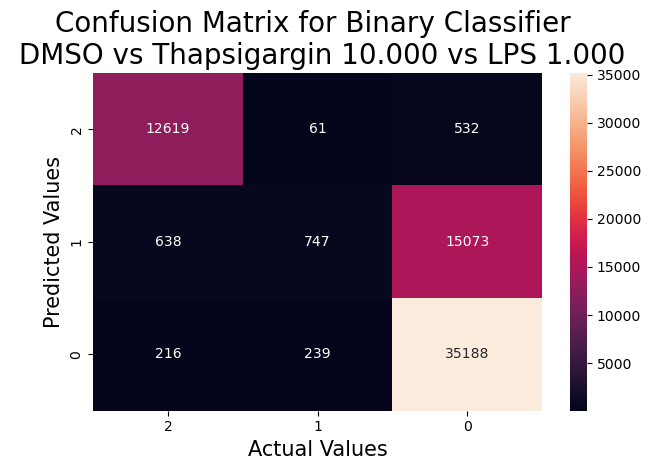

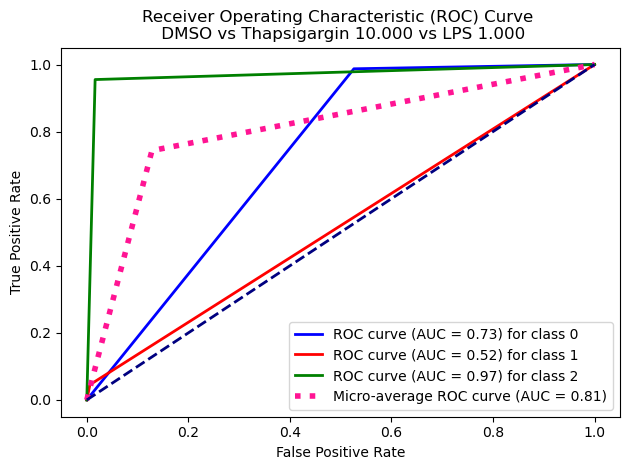

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.73      0.05      0.09     16810
           2       0.95      0.96      0.95     13212

    accuracy                           0.74     65665
   macro avg       0.79      0.66      0.62     65665
weighted avg       0.75      0.74      0.65     65665

Precision for class 0: 0.6872790484189144
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.7345132743362832
Recall for class 1: 0.04937537180249851
Precision for class 2: 0.94623575284943
Recall for class 2: 0.9551165607023918
3


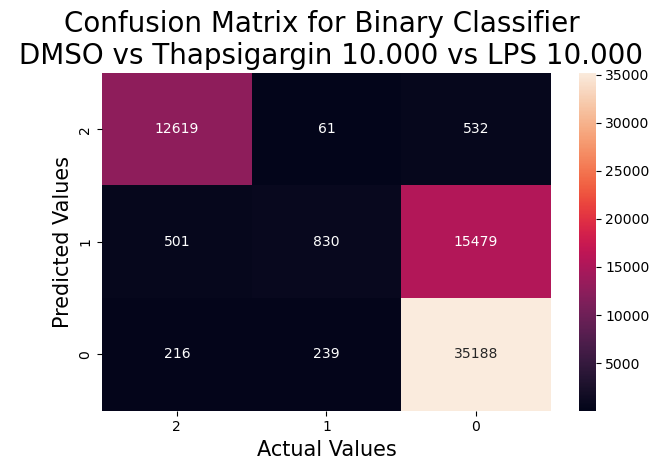

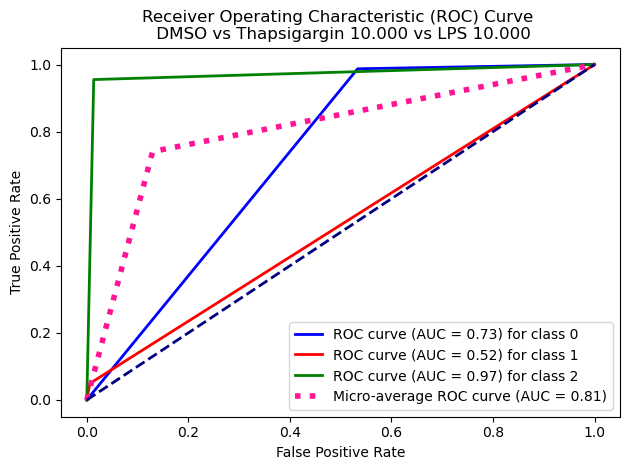

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     35643
           1       0.98      0.96      0.97     15987
           2       0.98      0.96      0.97     13212

    accuracy                           0.97     64842
   macro avg       0.98      0.97      0.97     64842
weighted avg       0.97      0.97      0.97     64842

Precision for class 0: 0.9692061918140252
Recall for class 0: 0.9872345201021239
Precision for class 1: 0.9808795411089866
Recall for class 1: 0.9626571589416401
Precision for class 2: 0.9823291296901759
Recall for class 2: 0.9551165607023918
3


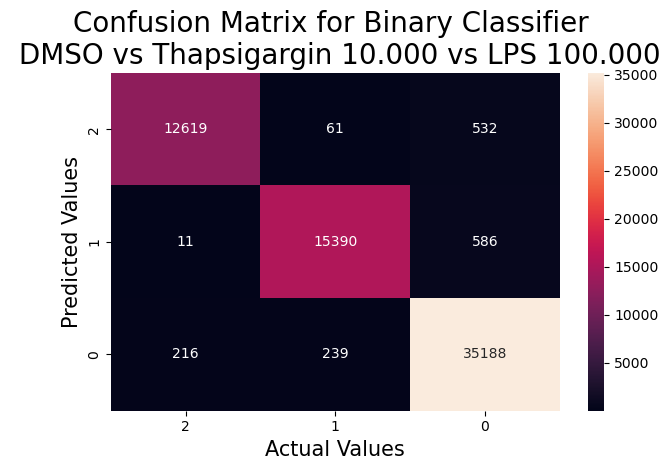

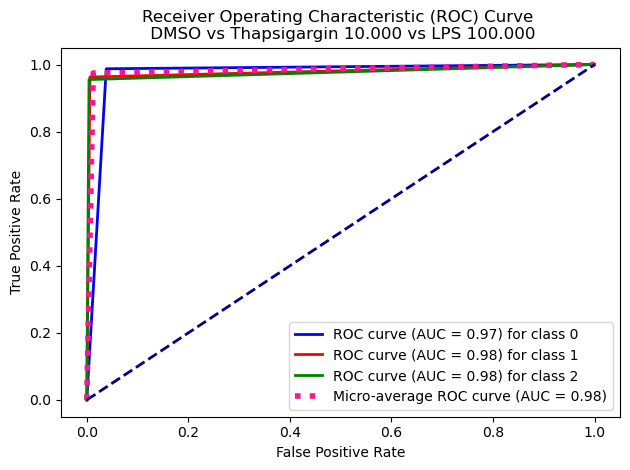

In [25]:
for i, j, k in paired_treatment_list:
    # print(i,j,k)
    test_df = df.query(
        f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{j}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{k}'"
    )
    output_name = (" ").join(
        test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )
    print(output_name)
    # title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])}'
    title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])} vs {(" ").join(output_name.split(" ")[2].split("_")[:2])}'

    test_loop(test_df, output_name, title)